# Jupyter notebook, from python to an ecFlow task
![jupyter](./logo_jupyter.png) http://jupyter.org/

# setup environment

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("/usr/local/apps/ecflow/4.8.0/lib/python2.7/site-packages/")
!module unload ecflow ; module load ecflow/4.8.0
import ecflow as ec
from ecflow import *

# start ecFlow server

In [2]:
%%bash
ecflow_start.sh -p 2500
ecflow_ui&


ping server(eurus:2500) succeeded in 00:00:00.001715  ~1 milliseconds
server is already started


# allow local ssh jobs submit
type into a shell:
```
ecflow_ui &

user=$USER; host=localhost
ssh $user@$host mkdir -p \$HOME/.ssh || :
cat \$HOME/.ssh/id_rsa.pub || ssh-keygen -t rsa -b 2048
cat \$HOME/.ssh/id_rsa.pub | ssh $user@$host 'cat >> \$HOME/.ssh/authorized_keys'
```

# import script

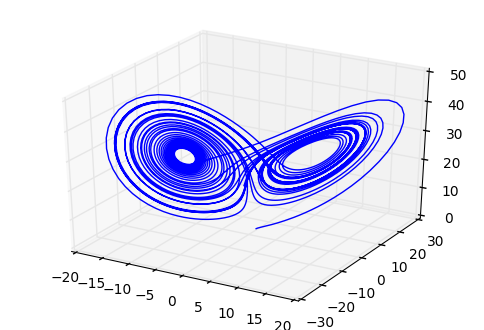

In [3]:
script = """# Thanks https://en.wikipedia.org/wiki/Lorenz_system
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state,
t):
  x, y, z = state  # unpack the state vector
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(states[:,0], states[:,1], states[:,2])
plt.show()"""
exec(script)

# define suite, create task template

In [4]:
import sys
# sys.path.append(os.getenv("HOME") + "/git/pyflow")
sys.path.append("/home/ma/map/git/pyflow")
import os
import pyflow as p

home = os.getenv("HOME") + "/eflow_server"
user = os.getenv("USER")
with p.Suite("lorenz", 
             ECF_HOME=home, ECF_INCLUDE=home, ECF_FILES=home, ECF_OUT=home, 
             ECF_EXTN=".ecf", USER=user, SCHOST="localhost",
             ECF_JOB_CMD="/home/ma/emos/bin/trimurti %USER% %SCHOST% %ECF_JOB% %ECF_JOBOUT%") as suite:
    p.Defstatus("suspended")
    with p.Family("course2018"):
        with p.Task("compute"):
            p.Script("python <<@@\n" + script + "\n@@")  # import script
        with p.Family("multi"):  # once imported, alter script, run multiple tasks
            for num in xrange (1,5):
                with p.Task("compute%d" % num):
                     p.Script("python <<@@\n" +  # a better choice may will be using ecflow variable
                         script.replace("[1.0, 1.0, 1.0]",
                                        "[%d.0, %d.0, 1.0]" % (num, num)) + "\n@@") 
suite.deploy_suite(overwrite=True)  # create task template files
suite.replace_on_server("localhost:2500") # replace the suite in the server
# TODO: separate data generation and plotting,
# TODO: run on different target (DISPLAY?)

Overwriting existing file: /home/ma/map/eflow_server/pyflow_head.h
Copy /home/ma/map/git/pyflow/pyflow/files/head.h to /home/ma/map/eflow_server/pyflow_head.h
Overwriting existing file: /home/ma/map/eflow_server/pyflow_tail.h
Copy /home/ma/map/git/pyflow/pyflow/files/tail.h to /home/ma/map/eflow_server/pyflow_tail.h
Overwriting existing file: /home/ma/map/eflow_server/lorenz/course2018/compute.ecf
Save /home/ma/map/eflow_server/lorenz/course2018/compute.ecf
Overwriting existing file: /home/ma/map/eflow_server/lorenz/course2018/multi/compute1.ecf
Save /home/ma/map/eflow_server/lorenz/course2018/multi/compute1.ecf
Overwriting existing file: /home/ma/map/eflow_server/lorenz/course2018/multi/compute2.ecf
Save /home/ma/map/eflow_server/lorenz/course2018/multi/compute2.ecf
Overwriting existing file: /home/ma/map/eflow_server/lorenz/course2018/multi/compute3.ecf
Save /home/ma/map/eflow_server/lorenz/course2018/multi/compute3.ecf
Overwriting existing file: /home/ma/map/eflow_server/lorenz/cour

# Extra

In [9]:
!pip install --user graphviz
import sys
sys.path.append("$HOME/.local/lib/python2.7/site-packages")
import graphviz
dot = suite.draw_tree()
dot.save("lorenz.dot")
suite.draw_graph()

In [6]:
!ecflow_client --port 2500 --begin /lorenz
!ecflow_client --port 2500 --resume /lorenz
!ecflow_client --port 2500 --ping
#!ecflow_client --help

ping server(localhost:2500) succeeded in 00:00:00.000686  ~0 milliseconds


In [7]:
!ecflow_client --port 2500 --requeue /lorenz  # when job not submitted/active!
